<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI286 - Computación Científica II</h1>
    <h1> Tarea 3: PDE Inpaiting </h1> 
    <h3>[V]íctor [T]orres [V]aras 201173076-3</h3>
</center>
<p>
<center>Febrero 2020 - v1.0 </center>
</p>

---

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize 

import imutils
import matplotlib.pyplot as plt
from numpy import linalg
from matplotlib.image import imread
from PIL import Image

## Contexto

_Inpaiting_ es el proceso mediante el cual se busca mejorar la calidad o restaurar una imagen que ha sufrido alteraciones o deterioros. En nuestro caso, el objetivo será reparar una imagen a la que le falta un conjunto de bits.

<img src="example.png" style="float:center;height:200px">

Existen muchas técnicas para poder reconstruir los bits faltantes, y seguramente a usted ya se le habrán ocurrido algunas maneras utilizando tecnicas vistas en Computación Científica (interpolación polinomial, splines) o en otras asignaturas. En este laboratorio le presentaremos una nueva técnica basada en ecuaciones diferenciales parciales.

La ecuación de calor es una PDE que modela como la temperatura de un cuerpo sólido se comporta a través del tiempo. Esta es una PDE del tipo parabólica y tiene la siguiente forma:

\begin{equation}
    u_t = \sigma\,\Delta u,
\end{equation}
donde $\sigma$ es un coeficiente de difusión.
Esta ecuación también se conoce como ecuación de difusión, pues describe como un valor (en este caso temperatura) se disipa. Consideremos la siguiente variación:

$$
    u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy},
$$

para "disipar" los valores de la imagen hacia los bits faltantes, donde $\sigma_x$ y $\sigma_y$ son valores reales. Un ejemplo del efecto de disipación sería el de la siguiente imagen:

<img src="dif.png" style="float:center;height:200px"><br>

Para definir el problema, debemos relacionar la EDP con la imagen y determinar cuales serían las condiciones iniciales y de borde apropiadas.
Consideremos que la imagen $I$ posee un conjunto de *missing values* en los pixeles $(c_x, c_y)$, de ancho $W$ y largo $H$.
Como se puede desprender de la imagen de ejemplo, las condiciones de borde corresponden a los pixeles conocidos que bordean al conjunto de *missing values* de la imagen. Esto significa que el dominio del problema corresponde a los *missing values* y los pixeles que rodean a este. Matemáticamente, podemos definir como dominio de la EDP  el conjunto $\Omega = [0, 1]^2$. La malla a utilizar para resolver numéricamente la EDP debe contener $W+2$ puntos en el eje $x$ (largo del dominio de *missing values* más dos puntos correspondientes a los pixeles conocidos) y $H+2$ puntos en el eje $y$. Sea $(x_i, y_j)$ un par en el borde del dominio, definiremos las condiciones de borde como

$$
    u(x_i, y_j, t) = I_{c_x+i, c_y+j}, \forall t > 0,
$$

donde $I_{n,m}$ corresponde al pixel en la posición $(n, m)$.

Para la condición inicial, idealmente necesitaríamos la imagen real (sin *missing values*). Sin embargo, esto es lo que deseamos encontrar. Sabemos que los pixeles al rededor de los *missing values* serán fijos (vienen de la imagen), por lo que podemos establecer cualquier valor arbitrario como valor inicial. Si consideramos que los pixeles son valores entre $0$ y $1$, entonces la condición inicial se define como:

$$
    u(x_i, y_j, 0) = 
    \begin{cases}
        I_{c_x+i, c_y+j}\quad&, \text{si }$(x_i, y_j)$ \text{corresponde al borde}, \\
        \alpha\quad&, \text{si }$(x_i, y_j)$ \text{corresponde a un punto interior},
    \end{cases}
$$
con $\alpha \in [0, 1]$.

Con esto tenemos los los elementos necesarios para aplicar *inpainting*! Un detalle importante es que la imagen es bidimensional, por lo que la EDP de calor tendrá dos dimensiones espaciales. 

## Sección 1 (60 puntos)

1. Discretice la ecuación de calor mediante Diferencias Finitas. Para el tiempo, utilice un esquema explícito.

Para poder obtener el Esquema explicito usaremos 2 aproximaciones, la primera sera para la 2da derivada parciales de variables espaciales, que es "Central Difference". La segunda para la variable temporal sera "Forward Difference":
Tomamos que $u(x,y,t) = U_{i,j,k}$

$\cdot$ Central Difference: 

$$
U_{xx} = \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2}
$$

$$
U_{yy} = \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2}
$$

Donde $\Delta$ es la diferencia entre los nodos vecinos, por lo que podemos decir que $\Delta x$ = $\Delta y$= 1

$\cdot$ Forward Difference: 

$$
U_{t} = \frac{U_{x,y,t+\Delta t} - U_{x,y,t}}{\Delta t}
$$

Luego debemos tomar lo anterior y reemplazarlo en la EDP original:

$$
    u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy},
$$


Nos queda de la siguiente forma:

$$
\frac{U_{x,y,t+\Delta t} - U_{x,y,t}}{\Delta t} = \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2}
$$ 

Como dice el enunciado, es necesario encontrar $u_{x,y,t}$ que serian los missing values, por lo que debemos en la ecuacion anterior despejar:

$$
{U_{x,y,t+\Delta t} - U_{x,y,t}} = {\Delta t} \cdot \left( \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2} \right)
$$ 

$$
{U_{x,y,t+\Delta t}}  =  U_{x,y,t} + {\Delta t} \cdot \left( \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2} \right)
$$ 

$$
{U_{x,y,t+\Delta t}}  =  U_{x,y,t} + \frac{\Delta t}{\Delta x^2} \cdot \sigma_x \cdot\left(  {U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}\right)  + \frac{\Delta t}{\Delta y^2}\cdot \cdot \sigma_y \cdot\left( {U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}} \right)
$$ 

2. Implemente un algoritmo que encuentre el sector de la imagen que posee los *missing values*, donde la imagen es representada como una matriz de *numpy*. Los *missing values* serán identificados mediante el valor `NaN`. Su algoritmo debe retornar la posición en donde empiezan los *missing values* (coordenada superior izquierda), y el ancho y largo del sector de *missing values*. Considere que los agujeros siempre tendrán forma rectangular.

In [2]:
'''
Input:
image - (array) matrix form of image
Output:
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
'''
#Se uso de Input el nombre del archivo para poder verificar las dimensiones y asi usar solo 2 de estas
#Dimensiones

def findHole(image):
    #img_nan = read_image_with_nan(image+'.npy')
    #img = read_image(image+'.png')
    #Vemos la dimension del la img para recorrerla
    if np.ndim(image) ==3:
        img_nan=image[:,:,0]
        print("Holi")
    else:
        img_nan=image
    x,y  = np.shape(img_nan)
    auxX = 0
    c=0
    auxY = 0
    countX = 0
    countY = 0
    lista =  []
    for i in range(x):
        for j in range(y):
            if np.isnan(img_nan[i,j]) == True:
                lista.append([i,j])
                c = c+1
                if auxX < j:
                    auxX = j
                    countX = countX + 1
                if auxY < i:
                    auxY=i
                    countY = countY + 1
    start=(lista[0][0], lista[0][1])    
    width=countX
    lenght=countY
    return start, width, lenght

Puede utilizar la siguiente función para cargar las imágenes con *missing values* (valores `NaN`):

In [4]:
# For npy files
def read_image_with_nan(path):
    return np.load(path, allow_pickle=True)
# For PNG files
def read_image(path):
    return imread(path, format='png')

In [5]:
img1 = read_image_with_nan('wave.npy')
start, width, lenght = findHole(img1)
print("start - lenght - width", start , lenght , width)

start - lenght - width (100, 100) 25 10


In [6]:
#cargamos una de las imagenes
img_nan = read_image_with_nan('wave.npy')
img = read_image('wave.png')


In [29]:
img_nan = read_image_with_nan('train_images/im2.npy')
img = read_image('train_images/im1.png')
start, width, lenght = findHole(img_nan)
print("start - lenght - width", start , lenght , width)

start - lenght - width (350, 250) 30 50


y la siguiente función para cargar imágenes comunes:

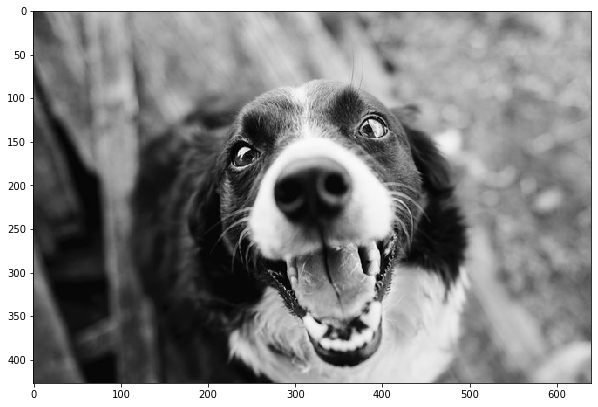

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

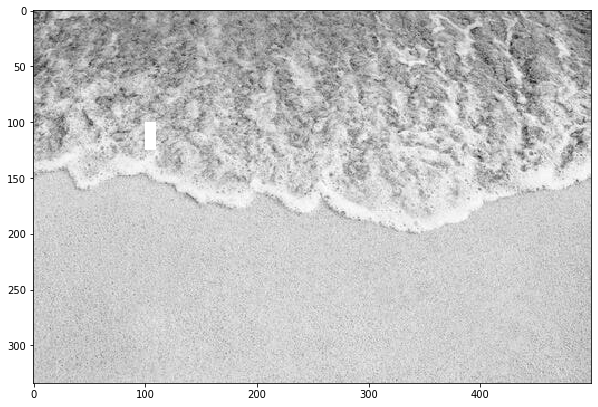

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(img_nan, cmap='gray')

3. Notar que la ecuación de calor está definida para todo $t > 0$. Sin embargo, sabemos que al ser difusiva tendrá un estado estacionario. Implemente un algoritmo que construya los pixeles faltantes de una imagen mediante el método planteado. Su algoritmo debe recibir la imagen a reconstruir, la ubicación de los pixeles faltantes, el valor $\alpha$ de inicio para la condición inicial, el coeficiente de difusión $\sigma$ y el *timestep*. Su algoritmo debe iterar hasta que se llegue a un estado aproximadamente estacionario. Indique como estimará si se ha llegado o no a dicho estado y justifique su elección.

Para construir el algoritmo se uso el código de JupyterNotebook del Curso, U4_HeatEquation y se le realizaron los cambios necesarios. Se considero el estado estacionario cuando la norma de u entre una iteración y la siguiente fuera menor a 10 cifras significantes, esto es por los colores que son poco diferenciables a simple vista.

In [9]:
#Código modificado del JupyterNotebook del Curso, U4_HeatEquation

#evolve solo lo hace para una iteracion aplicando la ecuacion discretizada, esto para u que contiene los nan y los bordes
#Luego se retorna la u_new que seria la modificacion de u_old. Ademas se modifico D, ya que en este caso tenemos asignado
#sigma para x e y respectivos

def evolve(u_new, u_old, dt, sigmax,sigmay, dx2, dy2):
    u_new[1:-1, 1:-1]  = u_old[1:-1, 1:-1]
    u_new[1:-1, 1:-1] += sigmax * dt * (u_old[2:, 1:-1] - 2*u_old[1:-1, 1:-1] + u_old[:-2, 1:-1]) / dx2 
    u_new[1:-1, 1:-1] += sigmay * dt * (u_old[1:-1, 2:] - 2*u_old[1:-1, 1:-1] + u_old[1:-1, :-2]) / dy2
    return u_new

#solver resuelve la u para los valores dados. Nx e Ny son las dimensiones respectivas. 
def solver(u0,sigmax, sigmay ,Nx=100, Ny=100, num_steps=100,dt=1):
    dx = 1./Nx
    dy = 1./Ny
    dx2 = dx**2
    dy2 = dy**2
    # For stability, this is the largest interval possible
    # for the size of the time-step:
    #dt = np.abs(1.0*dx2*dy2) / ( 2*sigmax*sigmay*(dx2+dy2) )
    print("Sigmax-SigmaY",sigmax,sigmay)
    
    # Usaremos el coeficiente de Courant-Friedrichs-Lewy (condición CFL)  para ver la convergencia de la EDP,  
    #de este modo sabremos si el dt es aplicable y converge. Por definicion este debe ser menor o igual a 0.5, 
    #si no lo esse debe continuar bajando para encontrar un punto de convergencia.
    CFL = dt*((sigmay/dy2)+ (sigmax/dx2))
    if CFL <= 0.5:
        print("Converge para dt:", dt)
    else:
        print("No converge para dt:",dt)
  
    
    #if sigmax==sigmay:
    #    dt = (1.0*dx2*dy2) / ( 2*sigmax*(dx2+dy2) )
        #dt=0.0001
    #    print('esto es if dt ',dt)
    #
    #else:
    #    dt = (1.0*dy/2*sigmay*dy2) + (1.0*dx/2*sigmax*dx2)
    #    print('esto es else dt ',dt)
    u_aux = u0
    u = u_aux
    all_sims = np.zeros([num_steps, Nx, Ny])
    
    for n in range(num_steps):
        evolve(u, u_aux,dt, sigmax,sigmay, dx2, dy2)
        u_aux = u
        all_sims[n,:,:] = u
        #Debemos tener un criterio de parada, el cual determine el momento en el que se produce un estado estacionario    
        if np.linalg.norm(all_sims[n,:,:]-all_sims[n-1,:,:], 'fro') < 10e-10:
            print('Valor de N iteraciones para el punto estacionario', n)
            return all_sims[:n,:,:]
    return all_sims

####################################################

In [10]:
'''
Input:
image - (array) matrix form of image
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
alpha - (float) A fixed value for initial condition
sigmax - (float) Fist difussion coefficient
sigmay - (float) Second difussion coefficient
dt - (float) time step
Output:
newImage - (array) matrix form of reconstructed image
'''
def fillHole(image, start, lenght, width, alpha, sigmax, sigmay, dt):
    newImage=image
    #Lo primero que hacemos es sleeccionar los lugares donde la img contiene los NaN, ademas debemos agregar las condiciones
    #de borde que agrega 2 dimensiones extra para x e y
    image = image[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]
    Nx, Ny = np.shape(image)
    #Conocemos donde estan los NaN por lo que reemplazamos por alpha como condiciones.
    image[1:-1,1:-1] = alpha
    #Se aplica a la img ya estructurada el solver
    image = solver(image, sigmax, sigmay, Nx, Ny,10000,dt)
    #image = solver2(image, D, Nx, Ny,10000)
    #Cuando se obtiene de solver la img, esta se agrega a la img completa
    newImage[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]= image[-1,:,:]
    return newImage


4. Evalúe su implementación con los valores de $\sigma_x = \sigma_y = 1$ y $\alpha = 0$. Comente en función de los resultados obtenidos.

Probamos para $\sigma_x = \sigma_y = 1$ y $\alpha = 0$.

Al tener $\sigma_x = \sigma_y = 1$ iguales entre ellos, no existe una diferencia en el aporte de cada uno, por lo que nos da una influencia en la resolucion igual. Como $\alpha = 0$ es un valor cercano como condicion inicial a los valores de la imagen, esto ayuda a que se demore menos en llegar al estado estacionario.
Consideramos entonces como unico factor variable $dt$, el cual notamos por la condicion de Courant-Friedrichs-Levy debe cumplir con ser menor a 0.5.

Tenemos 4 casos para $dt$, como vemos los primeros 3 no cumplen con CFL, por lo que al mirar la imagen de cada uno de ellos no logramos reparar la imagen dejando en blanco. Esto nos dice que no logra converger utilizando los valores de dt. Disinto es el caso de la última imagen, en ella notamos que si logra converger y cumple con CFL por lo que se repara.

start - lenght - width (100, 100) 25 10
Sigmax-SigmaY 1 1
No converge para dt: 0.1


/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in subtract
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in subtract
  # Remove the CWD from sys.path while we load stu

Sigmax-SigmaY 1 1
No converge para dt: 0.01
Sigmax-SigmaY 1 1
No converge para dt: 0.001
Sigmax-SigmaY 1 1
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 4428


Text(0.5, 1.0, 'Imagen para dt = 0.0001')

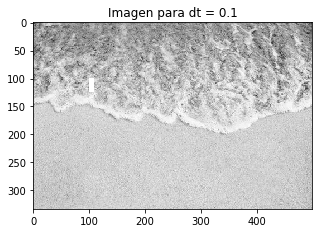

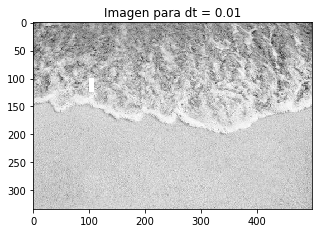

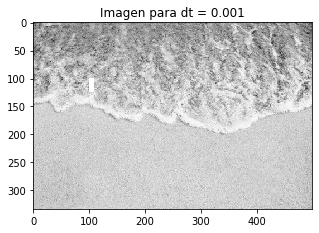

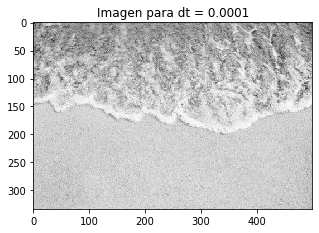

In [11]:
#Probamos para los valores dados.

#Usando la imagen wave, tomamos un dt= 0.1
img_nan = read_image_with_nan('wave.npy')
start, width, lenght = findHole(img_nan)
print("start - lenght - width", start , lenght , width)
alpha   = 1
sigmax  = 1
sigmay  = 1

img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt=0.1)
plt.figure(figsize=(5, 5))
plt.imshow(img_filled, cmap='gray')
plt.title('Imagen para dt = 0.1')

img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt=0.01)
plt.figure(figsize=(5, 5))
plt.imshow(img_filled, cmap='gray')
plt.title('Imagen para dt = 0.01')

img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt=0.001)
plt.figure(figsize=(5, 5))
plt.imshow(img_filled, cmap='gray')
plt.title('Imagen para dt = 0.001')

img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt=0.0001)
plt.figure(figsize=(5, 5))
plt.imshow(img_filled, cmap='gray')
plt.title('Imagen para dt = 0.0001')


## Sección 2 (60 puntos)

start - lenght - width (100, 100) 25 10
Sigmax-SigmaY 1 1
Converge para dt: 1e-05


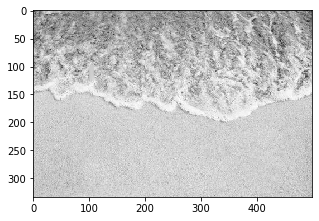

In [18]:
#img_nan = read_image_with_nan('train_images/im2.npy')
#start, width,lenght= findHole(img_nan)
img_nan = read_image_with_nan('wave.npy')
start, width, lenght = findHole(img_nan)
print("start - lenght - width", start , lenght , width)

img_filled = fillHole(img_nan, start, lenght,width,alpha=1, sigmax=1, sigmay=1, dt=0.00001)
plt.figure(figsize=(5, 5))
plt.imshow(img_filled, cmap='gray')


1. Aplique su algoritmo de la Sección 1 para distintos valores de $\sigma_x$, $\sigma_y$, $\alpha$ y *timestep*. Concluya al respecto. Recuerde considerar la estabilidad en la variación de los valores de $\sigma_x$ y $\sigma_y$.

R: Tomando distintos valores para $\sigma_x$, y  $\sigma_y$, tenemos 3 casos generales. El primero es cuando ambos son iguales, aca es importante notar que si bien para valores funcionan cuando son cercanos a una solución, cuando ambos son muy altos no converge, debido a que el valor de dt depende del valor de de sigmaX y sigmay. El segundo caso 
notamos que a medida que la diferencia entre ellos es más amplia, los resultados se ven influenciados por el que tenga el valor más alto. El tercer caso tenemos que sigmax es mayor que sigmay, acá no logramos que converja, como se menciono antes dt depende de estos valores por lo que por ello falla. Como tenemos mayores puntos para y, este puede aproximar mejor y no llega a un nan al hacer los calculos. 


Para el caso de $\alpha$, al ser el conjunto de soluciones iniciales, notamos que a medida que se aleja de la solución final que se espera se requieren más pasos, pero esto influye en cuanto tardare en llegar a un estado estacionario. Si tengo un alpha muy grande, este toma mas iteraciones. Por ejemplo tomamos un valor inicial de 20, este demoró 5057 iteraciones en llegar al un estado estacionario, pero si bajamos su valor, tomando alpha = 1, la cantidad de iteraciones disminuye hasta llegar solo a 3423(manteniendo los mismos valores para el resto de los parametros). El error es el mismo para ambos casos. 

Finalmente para timestep, se aprecia que cuando usamos CFL para establecer la convergencia, este juega un papel importante dado que si no cumple con la condicion no converge y falla. En primer caso ponemos un valor 0.1, que no converge pero al usar un valor 0.0001 cumple con CGL<0.5 y es asi como podemos obtener la imagen correspondiente reparada.





In [19]:
#Para usar los distintos valores de los parametros usaremos el $dt$ estable que obtuvimos de la pregunta anterior.
#Algoritmo para distintos valores de $\alpha$ 
alpha   = 20
sigmax  = 1.32
sigmay  = 1.32
dt      = 0.0001

img_nan = read_image_with_nan('wave.npy')

img = read_image('wave.png')
img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('alpha 1 :',alpha)

alpha   = 1
sigmax  = 1.32
sigmay  = 1.32
dt      = 0.0001

img_nan = read_image_with_nan('wave.npy')

img = read_image('wave.png')
img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('alpha 2:', alpha)


Sigmax-SigmaY 1.32 1.32
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 5057
Error:  1.0644546
alpha 1 : 20
Sigmax-SigmaY 1.32 1.32
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 3423
Error:  1.0644546
alpha 2: 1


In [20]:
#Algoritmo para distintos valores 
img_nan = read_image_with_nan('wave.npy')
img = read_image('wave.png')
alpha   = 1
sigmax  = 1.32
sigmay  = 1.32
dt      = 0.1
print('--- dt 0.1 ---\n')


img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('dt',dt)

alpha   = 1
sigmax  = 1.32
sigmay  = 1.32
dt      = 0.0001

print('--- dt 0.0001 ---\n')


img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('dt', dt)


#Algoritmo para distintos valores de $sigmax$ y $sigmay$ 

print('--- Sigmax = Sigmay ---\n')
alpha   = 1
sigmax  = 1
sigmay  = 1
dt      = 0.0001


img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('Sigmax:',sigmax)
print('Sigmay:',sigmay)

alpha   = 1
sigmax  = 1
sigmay  = 20
dt      = 0.0001
print('--- Sigmax < Sigmay ---\n')


img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('Sigmax:',sigmax)
print('Sigmay:',sigmay)

print('--- Sigmax > Sigmay ---\n')

alpha   = 1
sigmax  = 20
sigmay  = 1
dt      = 0.0001


img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('Sigmax:',sigmax)
print('Sigmay:',sigmay)




--- dt 0.1 ---

Sigmax-SigmaY 1.32 1.32
No converge para dt: 0.1


/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: 

Error:  nan
dt 0.1
--- dt 0.0001 ---

Sigmax-SigmaY 1.32 1.32
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 3423
Error:  1.0644546
dt 0.0001
--- Sigmax = Sigmay ---

Sigmax-SigmaY 1 1
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 4428
Error:  1.0645773
Sigmax: 1
Sigmay: 1
--- Sigmax < Sigmay ---

Sigmax-SigmaY 1 20
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 530
Error:  0.838784
Sigmax: 1
Sigmay: 20
--- Sigmax > Sigmay ---

Sigmax-SigmaY 20 1
No converge para dt: 0.0001
Error:  nan
Sigmax: 20
Sigmay: 1


In [21]:
#Algoritmo para distintos valores de $\alpha$ 
alpha   = 1
sigmax  = 1
sigmay  = 20
dt      = 0.0001

img_nan = read_image_with_nan('wave.npy')

img = read_image('wave.png')
img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('alpha',alpha)

alpha   = 1
sigmax  = 20
sigmay  = 1.
dt      = 0.0001

img_nan = read_image_with_nan('wave.npy')

img = read_image('wave.png')
img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)
print('alpha', alpha)

Sigmax-SigmaY 1 20
Converge para dt: 0.0001
Valor de N iteraciones para el punto estacionario 530
Error:  0.838784
alpha 1
Sigmax-SigmaY 20 1.0
No converge para dt: 0.0001


/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in subtract
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we loa

Error:  nan
alpha 1


2. Utilice la *Normal de Frobenius* para medir el error entre la imagen con *inpainting* y la imagen original. Mida el error para distintos valores de $\sigma_x$, $\sigma_y$, $\alpha$ y *timestep*. Concluya al respecto.

R: Utilizando los mismos casos de la pregunta anterior podemos ver el comportamiento del error.
Los casos donde falla y el error es nan, tenemos que no fue posible cumplir la condición CFL, esto ocurre por $\sigma_x$, $\sigma_y$ y $timestep$. Ahora el error cuando lo entrega. El caso de los sigma, tenemos que va depender de que tanto sea su aporte a la edp respecto a la imagen que nos toque evaluar. Si la imagen tiene mas influencia de $\sigma_y$ y nosotros elegimos un valor donde se aleje de esto, el error va aumentar. Lo mismo ocurre para $\sigma_x$.

En el caso de $\alpha$ como condicion inical aumenta el numero iteraciones para llegra al estado estacionario, pero este no afecta el error al menos que lo limitaramos o estuviera excesivamente alejado. Si hacemos por ejemplo solo 100 iteraciones, el valor de este aumentaria el error. En caso contrario, donde el valor sea cercano a la solucion, las 100 iteraciones podrian ser suficientes para que el error sea bajo. 

Sigmax-SigmaY 68.74997939 2.44280474
No converge para dt: 1e-05
Error:  1.305268


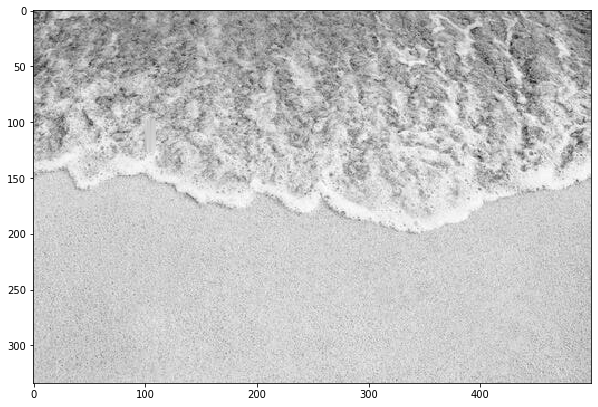

In [22]:
#Para la norma de Frobenius usaremos la libreria de numpy donde usaremos linalg.norm
#aplicamos el metodo y guardamos la img
alpha   = 1
sigmax  = 68.74997939  #65.44084170907746 
sigmay  = 2.44280474   #2.2953839853405054
dt      = 0.00001
img_nan = read_image_with_nan('wave.npy')

img = read_image('wave.png')
img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

plt.figure(figsize=(10, 10))
plt.imshow(img_filled, cmap='gray')
error = np.linalg.norm(img - img_filled, 'fro')
print("Error: ",error)


3. Proponga un algoritmo que permita *optimizar* el valor de $\sigma_x$ y $\sigma_y$ respecto a la norma de Frobenius. Para esta sección elija un valor de $\alpha$ fijo, en función de los experimentos realizados en las preguntas 1 y 2 de la sección 2. Su algoritmo debe *optimizar* utilizando las imágenes dentro de la carpeta `train_images`. Una vez obtenidos los valores de $\sigma_x$ y $\sigma_y$, evalúe el desempeño con las imágenes de `train_images`. Comente y concluya en función de sus resultados.

Para realizar la optimizacion de $\sigma_x$ y $\sigma_y$ utilizamos fmin de scipy. La idea es declarar  una funcion que recibe como parámetro el valor de ambos sigmas y retorna el valorde la norma de Frobenius como el error luego de calcular la imagen con el algoritmo de la pregunta anterior. Al buscar la minimizacion del error se busca que los valores se ambos sigmas baje, de tal forma que se encuentre un óptimo. Esta forma es muy sensible a los valores iniciales, por ello existen casos donde retorna los mismos valores iniciales y la optimizacion no se realiza de forma adecuada. 
La im4 se ve que al pasarle los valores logra optimizar, y entrega un optimo para esos valores de entrada. Si estos se alejan de la solucion que buscamos, el numero de iteraciones que se realizan aumenta, por ello si alguno de los sigma esta muy lejos puede llegar a fallar y caer en optimizacion de valores donde el CFL no se cumple y da valores erroneos. Las imagenes donde dt es muy pequeño fallan, esto nos dice que si bien puede uno entregar valores para cada sigma y utilizarlos para encontrar un error no seria una enterpretacion correcta.

PD: En la lista de optimizacion, algunos valores no convergen pero aun asi los toma como optimos, esto dado que el algoritmo no tiene soporte para esta situacion, hay que buscar en los valores imprimidos el ultimo que cumple con CFL y converge.
PD2: Se uso el Método Nelder-Mead dado que busca de modo aproximado una solución óptima local a un problema con N variables cuando la función a minimizar varía suavemente.

In [23]:
def opt(x):
        img_nan = read_image_with_nan('train_images/im4.npy')
        img = read_image('train_images/im4.png')
        start, width, lenght = findHole(img_nan)
        
        alpha   = 0
        sigmax  = x[0]
        sigmay  = x[1]

        dt      = 0.00001
        img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)
    
        return np.linalg.norm(img - img_filled, 'fro')



w=np.array([1, 1])
#resultado = scipy.optimize.minimize(opt,w, method='TNC', tol=1e-15)
resultado = scipy.optimize.fmin(opt,w)

print(resultado)

Sigmax-SigmaY 1.0 1.0
Converge para dt: 1e-05
Sigmax-SigmaY 1.05 1.0
Converge para dt: 1e-05
Sigmax-SigmaY 1.0 1.05
Converge para dt: 1e-05
Sigmax-SigmaY 1.0499999999999998 1.0499999999999998
Converge para dt: 1e-05
Sigmax-SigmaY 1.0749999999999997 1.0749999999999997
Converge para dt: 1e-05
Sigmax-SigmaY 1.125 1.0249999999999997
Converge para dt: 1e-05
Sigmax-SigmaY 1.1875 1.0124999999999997
Converge para dt: 1e-05
Sigmax-SigmaY 1.2124999999999997 1.0874999999999995
Converge para dt: 1e-05
Sigmax-SigmaY 1.2937499999999997 1.1312499999999992
Converge para dt: 1e-05
Sigmax-SigmaY 1.40625 1.0687499999999992
Converge para dt: 1e-05
Sigmax-SigmaY 1.5718750000000004 1.065624999999999
Converge para dt: 1e-05
Sigmax-SigmaY 1.678125 1.1843749999999984
Converge para dt: 1e-05
Sigmax-SigmaY 1.9234375000000004 1.2703124999999975
Converge para dt: 1e-05
Sigmax-SigmaY 2.201562500000001 1.2046874999999972
Converge para dt: 1e-05
Sigmax-SigmaY 2.6554687500000016 1.2414062499999963
Converge para dt: 1e

/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in subtract
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':


Sigmax-SigmaY 44.519815063476614 4.714425659179605
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2458
Sigmax-SigmaY 72.33859558105479 6.272915649413935
No converge para dt: 1e-05
Sigmax-SigmaY 51.47451019287116 5.1040481567381875
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2160
Sigmax-SigmaY 44.14913177490242 3.221272277831959
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2537
Sigmax-SigmaY 35.1777503967286 1.6143791198729964
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 3164
Sigmax-SigmaY 38.46975631713877 1.0626136779784652
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2962
Sigmax-SigmaY 31.967379379272572 -0.958103561401396
Converge para dt: 1e-05


/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


Sigmax-SigmaY 18.88099060058603 -1.8752899169921946
Converge para dt: 1e-05
Sigmax-SigmaY 45.7951347351075 2.9453895568846935
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2470
Sigmax-SigmaY 27.852371978759855 -0.2683967590332319
Converge para dt: 1e-05
Sigmax-SigmaY 41.30944404602059 2.141942977905212
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2706
Sigmax-SigmaY 32.33806266784677 0.5350498199462494
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 3469
Sigmax-SigmaY 39.06659870147713 1.7402196884154715
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2904
Sigmax-SigmaY 42.358604621887295 1.1884542465209402
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2718
Sigmax-SigmaY 45.949031734466644 0.9754918098449119
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2542
Sigmax-SigmaY 41.76176223754892 0.5108482360839339
Converge para dt

Sigmax-SigmaY 68.75001852638239 2.44263197638963
No converge para dt: 1e-05
Sigmax-SigmaY 68.75096038518959 2.44276915554735
No converge para dt: 1e-05
Sigmax-SigmaY 68.7498784024933 2.4428545785007474
No converge para dt: 1e-05
Sigmax-SigmaY 68.75020565777046 2.442811113296747
No converge para dt: 1e-05
Sigmax-SigmaY 68.74935071348659 2.442808098387539
No converge para dt: 1e-05
Sigmax-SigmaY 68.74975313141233 2.4427983626774914
No converge para dt: 1e-05
Sigmax-SigmaY 68.7498533482771 2.442843335336096
No converge para dt: 1e-05
Sigmax-SigmaY 68.75004241774856 2.4427854393126305
No converge para dt: 1e-05
Sigmax-SigmaY 68.7499793945914 2.442804737987119
No converge para dt: 1e-05
Sigmax-SigmaY 68.75015554933809 2.4427886269674444
No converge para dt: 1e-05
Sigmax-SigmaY 68.75002950302378 2.4428272243164217
No converge para dt: 1e-05
Sigmax-SigmaY 68.75006101460235 2.4428175749791774
No converge para dt: 1e-05
Sigmax-SigmaY 68.7498347514233 2.442811199669549
No converge para dt: 1e-05

In [30]:
def opt2(x):
        img_nan = read_image_with_nan('train_images/im2.npy')
        img = read_image('train_images/im2.png')
        start, width, lenght = findHole(img_nan)
        
        alpha   = 0
        sigmax  = x[0]
        sigmay  = x[1]

        dt      = 0.00001
        img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)
    
        return np.linalg.norm(img - img_filled, 'fro')



w=np.array([1, 1])
resultado = scipy.optimize.fmin(opt2,w)

print(resultado)

Sigmax-SigmaY 1.0 1.0
Converge para dt: 1e-05
Sigmax-SigmaY 1.05 1.0
Converge para dt: 1e-05
Sigmax-SigmaY 1.0 1.05
Converge para dt: 1e-05
Sigmax-SigmaY 1.0499999999999998 1.0499999999999998
Converge para dt: 1e-05
Sigmax-SigmaY 1.0749999999999997 1.0749999999999997
Converge para dt: 1e-05
Sigmax-SigmaY 1.125 1.0249999999999997
Converge para dt: 1e-05
Sigmax-SigmaY 1.1875 1.0124999999999997
Converge para dt: 1e-05
Sigmax-SigmaY 1.2124999999999997 1.0874999999999995
Converge para dt: 1e-05
Sigmax-SigmaY 1.2937499999999997 1.1312499999999992
Converge para dt: 1e-05
Sigmax-SigmaY 1.40625 1.0687499999999992
Converge para dt: 1e-05
Sigmax-SigmaY 1.5718750000000004 1.065624999999999
Converge para dt: 1e-05
Sigmax-SigmaY 1.678125 1.1843749999999984
Converge para dt: 1e-05
Sigmax-SigmaY 1.9234375000000004 1.2703124999999975
Converge para dt: 1e-05
Sigmax-SigmaY 2.201562500000001 1.2046874999999972
Converge para dt: 1e-05
Sigmax-SigmaY 2.6554687500000016 1.2414062499999963
Converge para dt: 1e

/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':


Sigmax-SigmaY 35.04709472656253 6.546752929687422
No converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2972
Sigmax-SigmaY 44.61042480468753 7.535180664062402
No converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 2489
Sigmax-SigmaY 49.39208984375004 8.029394531249892
No converge para dt: 1e-05
Sigmax-SigmaY 28.771899414062517 4.8274169921874375
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 3577
Sigmax-SigmaY 19.28383789062501 3.0437011718749574
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 5074
Sigmax-SigmaY 31.984765625000016 4.89179687499993
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 3288
Sigmax-SigmaY 32.022399902343764 4.49415283203118
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 3349
Sigmax-SigmaY 6.69581298828124 0.0026733398437350786
Converge para dt: 1e-05
Sigmax-SigmaY 35.13177185058596 5.652053833007735
No converge p

Valor de N iteraciones para el punto estacionario 6329
Sigmax-SigmaY 15.461131353765811 1.9842105582479803
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6312
Sigmax-SigmaY 15.460718136965621 1.984211948863015
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6306
Sigmax-SigmaY 15.448984662786277 1.9827743625484464
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6331
Sigmax-SigmaY 15.452021335531162 1.9831334114733297
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6326
Sigmax-SigmaY 15.458094681020926 1.983851509323097
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6349
Sigmax-SigmaY 15.453539671903602 1.9833129359357715
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6295
Sigmax-SigmaY 15.442219414524448 1.981873959006168
Converge para dt: 1e-05
Valor de N iteraciones para el punto estacionario 6301
Sigmax-SigmaY 15.45609345635532

## Sección 3 (50 puntos)

1. Discretice la ecuación de calor para usarla en este problema, usando un esquema implícito. Incluya una imagen de los stencil explícitos e implícitos y comparelos.

Para poder obtener el Esquema implitico usaremos 3 aproximaciones, 2 se basan en la 2da derivada parciales de variables espaciale. La la ultima para la variable temporal.

$\cdot$ Esquema Implicito, Aproximaciones: 

$$
U_{xx} = \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2}
$$

$$
U_{yy} = \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2}
$$


$\cdot$ Backward Difference: 

$$
U_{t} = \frac{U_{x,y,t} - U_{x,y,t-\Delta t}}{\Delta t}
$$

Luego debemos tomar lo anterior y reemplazarlo en la EDP original:

$$
    u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy},
$$


Nos queda de la siguiente forma:

$$
 \frac{U_{x,y,t} - U_{x,y,t-\Delta t}}{\Delta t} = \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2}
$$ 

Como dice el enunciado, es necesario encontrar $u_{x,y,t}$ que serian los missing values, por lo que debemos en la ecuacion anterior despejar:

$$
{U_{x,y,t-\Delta t} - U_{x,y,t}} = {\Delta t} \cdot \left( \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2} \right)
$$ 

$$
{U_{x,y,t-\Delta t}}  =  U_{x,y,t} + {\Delta t} \cdot \left( \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2} \right)
$$ 

$$
{U_{x,y,t-\Delta t}}  =  U_{x,y,t} + \frac{\Delta t}{\Delta x^2} \cdot \sigma_x \cdot\left(  {U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}\right)  + \frac{\Delta t}{\Delta y^2}\cdot \cdot \sigma_y \cdot\left( {U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}} \right)
$$ 

Como necesitamos que comience desde el primer elemento para ocuparar el anterior en cada una de las iteraciones, usaremos el cambio para un k >= 0, por lo que ahora reemplazamos t = k+1 y  $u(x,y,t) = U_{i,j,k}$
:

$$
{U_{i,j,k+1}}  =  U_{i,j,k} + \frac{\Delta t}{\Delta x^2} \cdot \sigma_x \cdot\left(  {U_{i+1,j,k+1} - 2U_{i,j,k+1} + U_{i-1,y,k+1}}\right)  + \frac{\Delta t}{\Delta y^2}\cdot \sigma_y \cdot\left( {U_{i,j+1 ,k+1} - 2U_{i,j,k+1} + U_{i,j-1,k+1}} \right)
$$ 


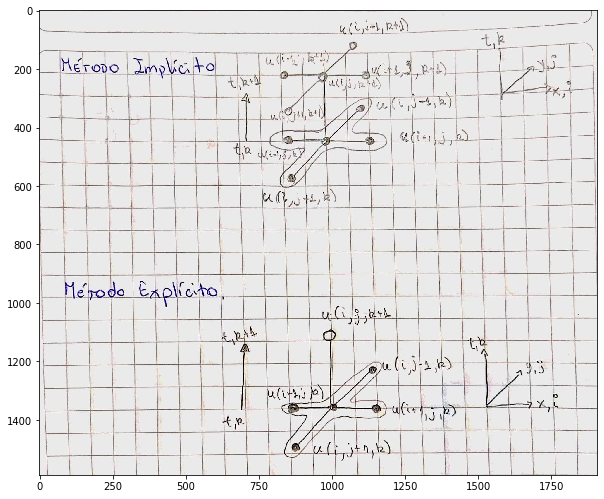

In [31]:
#Stencil para cada método
import imageio
stencil = imageio.imread('stencil.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(stencil, cmap='gray')

2. Modifique el código desarrollado en la pregunta 3 de la sección anterior para que reconstruya la imagen usando un esquema implícito. 

Pd. No funciona, al crear la Matriz para resolver el sistema de ecuaciones no pude insertar los valores. Se realiza bajo supuestos, solo de la teoria se sacaron conclusiones.

Para constrir el metodo debemos agrupar los terminos anteriores, asi podremos manejar la matriz para cada una de las iteraciones
$$
{U_{i,j,k+1}}  =  U_{i,j,k} + \frac{\Delta t}{\Delta x^2} \cdot \sigma_x \cdot\left(  {U_{i+1,j,k+1} - 2U_{i,j,k+1} + U_{i-1,y,k+1}}\right)  + \frac{\Delta t}{\Delta y^2}\cdot \sigma_y \cdot\left( {U_{i,j+1 ,k+1} - 2U_{i,j,k+1} + U_{i,j-1,k+1}} \right)
$$ 

$$ A =  \frac{\Delta t}{\Delta x^2} \cdot \sigma_x $$
$$ B = \frac{\Delta t}{\Delta y^2} \cdot \sigma_y $$

$$
{U_{i,j,k+1}}  =  U_{i,j,k} + A \cdot \left(  {U_{i+1,j,k+1} - 2U_{i,j,k+1} + U_{i-1,y,k+1}}\right)  + B \cdot\left( {U_{i,j+1 ,k+1} - 2U_{i,j,k+1} + U_{i,j-1,k+1}} \right)
$$ 

Entonces al igual que el metodo explicito debemos establecer un solver y evolver para ir iterando:

In [1]:
'''
Input:
image - (array) matrix form of image
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
alpha - (float) A fixed value for initial condition
sigmax - (float) Fist difussion coefficient
sigmay - (float) Second difussion coefficient
dt - (float) time step
Output:
newImage - (array) matrix form of reconstructed image
'''
def evolveImplicit(u_new, u_old, dt, sigmax,sigmay, dx2, dy2,M):
    A = dt*sigmax/dx2
    B = dt*sigmay/dy2
    Nx,Ny = np.shape(M)
    #Ahora se debe resolver para cada valor de i en el sistema que se contiene en M
    #for i in range(Nx)
    u_new[1:-1, 1:-1]  = u_old[1:-1, 1:-1]
    u_new[1:-1, 1:-1] += A * (u_old[2:, 1:-1] - 2*u_old[1:-1, 1:-1] + u_old[:-2, 1:-1])
    u_new[1:-1, 1:-1] += B* (u_old[1:-1, 2:] - 2*u_old[1:-1, 1:-1] + u_old[1:-1, :-2]) 
    
    return u_new

#solver resuelve la u para los valores dados. Nx e Ny son las dimensiones respectivas. 
def solverImplicit(u0,sigmax, sigmay ,Nx=100, Ny=100, num_steps=100,dt=1):
    dx = 1./Nx
    dy = 1./Ny
    dx2 = dx**2
    dy2 = dy**2

    u_aux = u0
    u = u_aux
    all_sims = np.zeros([num_steps, Nx, Ny])
    #Acá es necesario formar una matriz M de la forma y resolver el sistema de ecuaciones M*u^j = u^(j-1): 
    M = np.zeros([Nx,Ny])

    for n in range(num_steps):        
            evolveImplicit(u, u_aux,dt, sigmax,sigmay, dx2, dy2,M)
            u_aux = u
            all_sims[n,:,:] = u
            #Debemos tener un criterio de parada, el cual determine el momento en el que se produce un estado estacionario    
            if np.linalg.norm(all_sims[n,:,:]-all_sims[n-1,:,:], 'fro') < 10e-10:
                print('Valor de N iteraciones para el punto estacionario', n)
                return all_sims[:n,:,:]
    return all_sims



def fillHoleImplicit(image, start, width, lenght, alpha, sigmax, sigmay, dt):
    newImage=image
    image = image[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]
    Nx, Ny = np.shape(image)
    image[1:-1,1:-1] = alpha
    
    image = solver(image, sigmax, sigmay, Nx, Ny,10000,dt)

    newImage[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]= image[-1,:,:]

    return newImage

3. Utilice la *Normal de Frobenius* para medir el error entre la imagen con *inpainting* y la imagen original. Mida el error para distintos *timestep*. Concluya en función de los resultados y en comparación con el uso de un método explícito.

La principal diferencia que existe entre ambos métodos refiriendonos a la estabilidad de cada uno es que el proceso implícito es incondicionalmente estable, lo cual  significa  que  para  todos  los  valores del  paso  de  tiempo,  los  errores  se  disiparán con el tiempo. Nos dice que ahora cada vez que avanzamos llegaremos a una estabilidad disipando el error, pero esto tiene un costo. Los timestep cuando son muy pequeños van a producir error, debido a la cantidad de pasos que son necesarios, lo que hace que resulte mas costoso ya que en cada pasado debemos volver a calcular los valores de la matriz. El método explicito es menos costoso pero como vimos tiende a a fallar en la convergencia.

In [2]:
alpha   = 1
sigmax  = 1
sigmay  = 1
dt      = 0.00001
img_nan = read_image_with_nan('wave.npy')
img = read_image('wave.png')

img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)
#img_filled2 = fillHoleImplicit(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

plt.figure(figsize=(10, 10))
plt.imshow(img_filled, cmap='gray')
error = np.linalg.norm(img_filled2 - img_filled, 'fro')
print("Error: ",error)


NameError: name 'read_image_with_nan' is not defined

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

---

# Referencias
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
* https://es.wikipedia.org/wiki/M%C3%A9todo_Nelder-Mead
* http://mmc2.geofisica.unam.mx/cursos/hidrogeologia/NotasCurso/1-MDF-06-Notas.pdf
* https://relopezbriega.github.io/blog/2017/01/18/problemas-de-optimizacion-con-python/
* https://www.inf.utfsm.cl/~parce/cc2/clase16-PA.html